In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

### Loading Starting Moneyline Data

In [17]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')[['pos_money','neg_money']]
df

,pos_money,neg_money
0,380,-500
1,340,-500
2,400,-550
3,400,-550
4,400,-525
...,...,...
31,400,-520
32,375,-500
33,400,-550
34,340,-450


#### Empirical Starting Moneyline Distribution

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


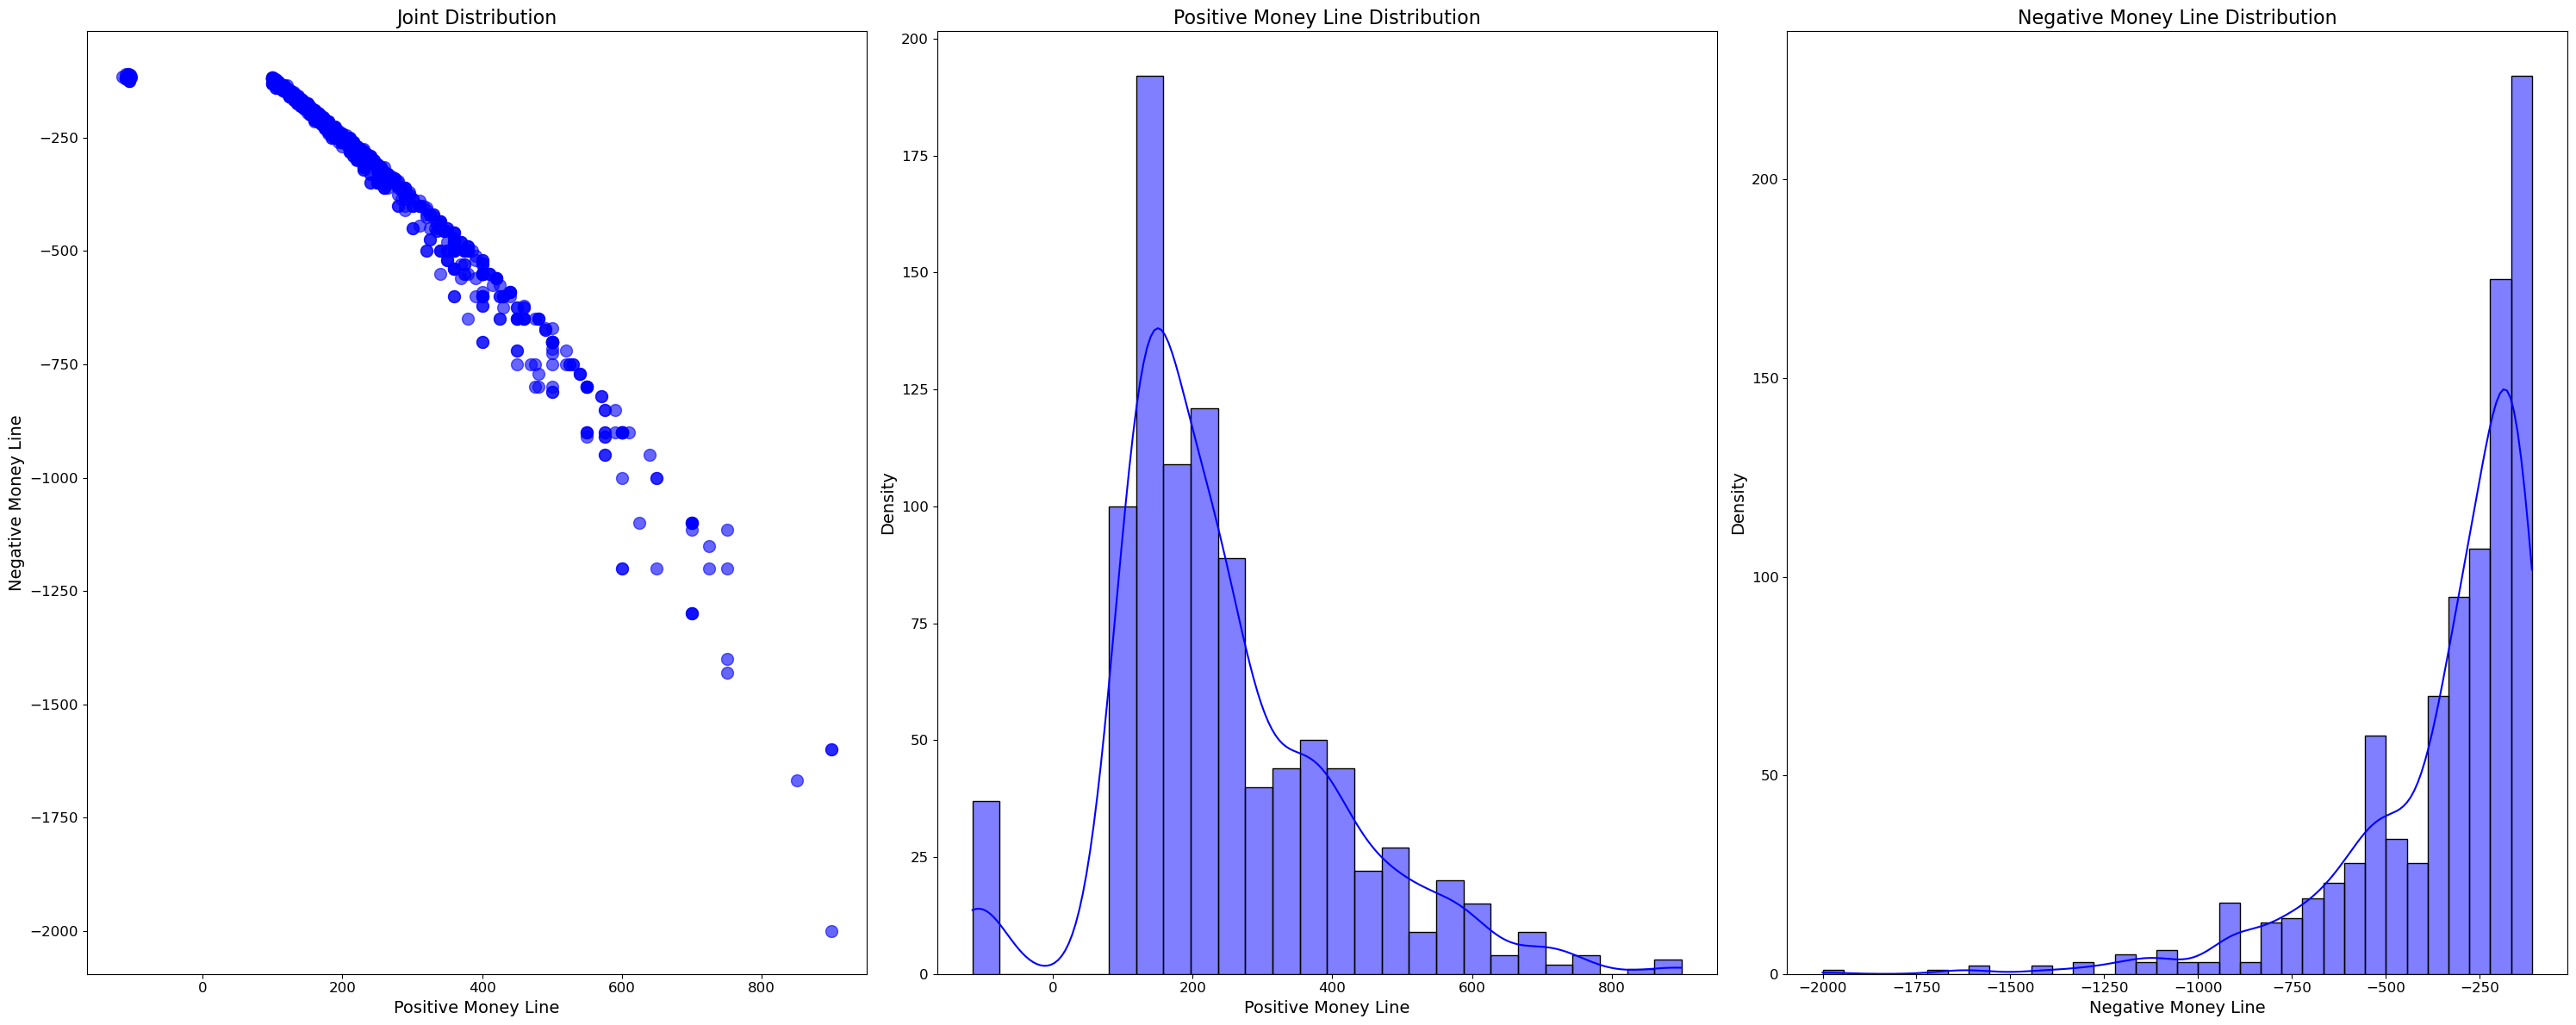

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 12))

# Joint distribution
ax1.scatter(df['pos_money'], df['neg_money'], color='blue', alpha=0.6, s=100)
ax1.set_title('Joint Distribution', fontsize=16)
ax1.set_xlabel('Positive Money Line', fontsize=14)
ax1.set_ylabel('Negative Money Line', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Positive moneyline distribution
sns.histplot(df['pos_money'], kde=True, color='blue', ax=ax2)
ax2.set_title('Positive Money Line Distribution', fontsize=16)
ax2.set_xlabel('Positive Money Line', fontsize=14)
ax2.set_ylabel('Density', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Negative moneyline distribution  
sns.histplot(df['neg_money'], kde=True, color='blue', ax=ax3)
ax3.set_title('Negative Money Line Distribution', fontsize=16)
ax3.set_xlabel('Negative Money Line', fontsize=14)
ax3.set_ylabel('Density', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

##### Converting df to array

In [19]:
data = df.values.astype(np.float32)
data.shape

(942, 2)

## Spectral Normalization, Larger Network with Dropout

In [ ]:
# Create a PyTorch dataset and dataloader
# Convert data to PyTorch tensor
scaler = MinMaxScaler()
real_data = torch.tensor(data)
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization, Dropout, and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Spectral Normalization, Dropout, and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 1)),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

# Lists to store loss values for visualization
losses_G = []
losses_C = []

# Training loop
for epoch in range(1, n_epochs + 1):
    for i, data_batch in enumerate(dataloader):
        real_samples = data_batch[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Store losses for plotting
    losses_G.append(loss_G.item())
    losses_C.append(loss_C.item())

    if epoch % 500 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(len(real_data), noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Convert to DataFrames for easier plotting
real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])


Using device: cpu
Epoch 1, Loss C: -226.6495, Loss G: -1.2935
